In [1]:
from models import  ResNetvae_EUCL, vae_hyp_celeba, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 102400))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=64, 
                                         num_workers=1, pin_memory=True, shuffle=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

In [4]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [5]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            print(x.shape)
            loss = ((x - x_hat)**2).sum() 
            #+ vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [6]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      img = img.to(device)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


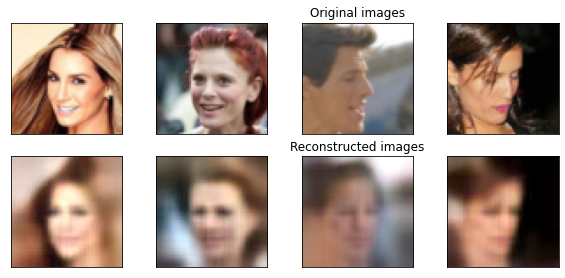

	 partial train loss (single batch): 8564.133789
	 partial train loss (single batch): 8846.523438
	 partial train loss (single batch): 9278.084961
	 partial train loss (single batch): 9171.781250
	 partial train loss (single batch): 7961.127441
	 partial train loss (single batch): 10929.275391
	 partial train loss (single batch): 8210.883789
	 partial train loss (single batch): 8439.920898
	 partial train loss (single batch): 9200.125000
	 partial train loss (single batch): 9366.909180
	 partial train loss (single batch): 9554.770508
	 partial train loss (single batch): 8489.707031
	 partial train loss (single batch): 9947.110352
	 partial train loss (single batch): 8444.505859
	 partial train loss (single batch): 9327.702148
	 partial train loss (single batch): 9633.223633
	 partial train loss (single batch): 10154.501953
	 partial train loss (single batch): 8711.588867
	 partial train loss (single batch): 9319.333984
	 partial train loss (single batch): 8124.425293
	 partial train lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


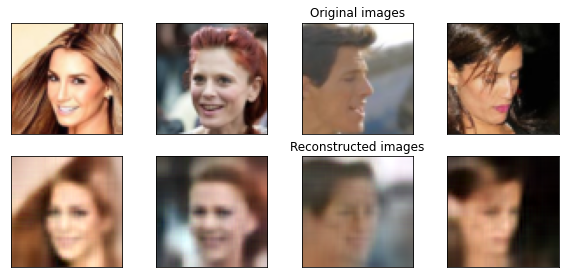

	 partial train loss (single batch): 6093.929688
	 partial train loss (single batch): 5495.216309
	 partial train loss (single batch): 6510.906738
	 partial train loss (single batch): 6259.805664
	 partial train loss (single batch): 5934.693848
	 partial train loss (single batch): 6061.898438
	 partial train loss (single batch): 6756.535156
	 partial train loss (single batch): 5858.661133
	 partial train loss (single batch): 6146.353516
	 partial train loss (single batch): 5593.556152
	 partial train loss (single batch): 6521.693359
	 partial train loss (single batch): 5958.823730
	 partial train loss (single batch): 6633.446289
	 partial train loss (single batch): 6091.993652
	 partial train loss (single batch): 6346.726562
	 partial train loss (single batch): 6637.867676
	 partial train loss (single batch): 7047.187012
	 partial train loss (single batch): 5588.861328
	 partial train loss (single batch): 6469.188965
	 partial train loss (single batch): 6133.741699
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


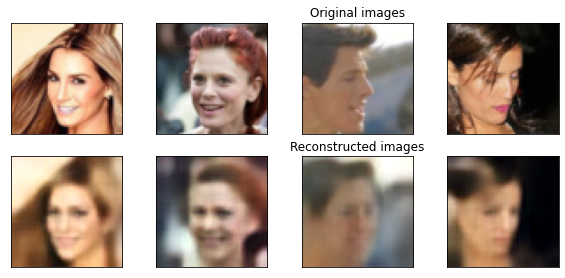

	 partial train loss (single batch): 5615.543945
	 partial train loss (single batch): 5256.976562
	 partial train loss (single batch): 5969.979492
	 partial train loss (single batch): 5991.562012
	 partial train loss (single batch): 5607.287109
	 partial train loss (single batch): 5720.402832
	 partial train loss (single batch): 7121.070801
	 partial train loss (single batch): 5883.754883
	 partial train loss (single batch): 6180.849121
	 partial train loss (single batch): 6123.220215
	 partial train loss (single batch): 6839.795410
	 partial train loss (single batch): 5284.185547
	 partial train loss (single batch): 6608.507812
	 partial train loss (single batch): 6361.126465
	 partial train loss (single batch): 5636.020508
	 partial train loss (single batch): 5354.579590
	 partial train loss (single batch): 6391.839844
	 partial train loss (single batch): 5545.958496
	 partial train loss (single batch): 6069.212402
	 partial train loss (single batch): 5803.173828
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


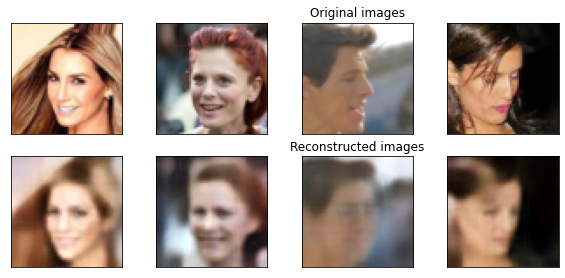

	 partial train loss (single batch): 5931.447266
	 partial train loss (single batch): 5285.467773
	 partial train loss (single batch): 5672.154785
	 partial train loss (single batch): 5313.188965
	 partial train loss (single batch): 5958.489258
	 partial train loss (single batch): 6483.967773
	 partial train loss (single batch): 5775.414062
	 partial train loss (single batch): 6043.219727
	 partial train loss (single batch): 6020.007324
	 partial train loss (single batch): 5462.899414
	 partial train loss (single batch): 5107.886230
	 partial train loss (single batch): 6005.074219
	 partial train loss (single batch): 5220.446289
	 partial train loss (single batch): 5545.596680
	 partial train loss (single batch): 6180.133301
	 partial train loss (single batch): 5444.696289
	 partial train loss (single batch): 5487.884277
	 partial train loss (single batch): 5222.912598
	 partial train loss (single batch): 5774.612305
	 partial train loss (single batch): 4933.786621
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


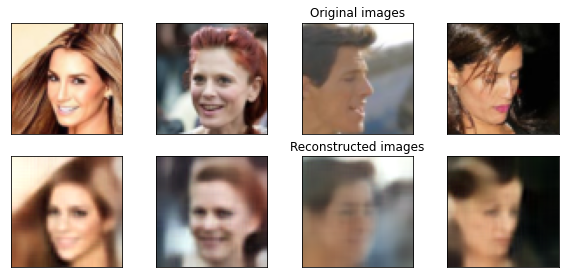

In [7]:
#model = vae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=100, device=device)
model = vae_hyp_celeba.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=500, device=device)
model.to(device)
print(model)
epochs = 5
learning_rate = 5e-4

optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model, trainloader, optimizer)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)


# save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/resnet_model.pth')

#Resuming Model Training

In [8]:
# # load the trained model
# model_resume = model.to(device) # initilize the model
# # initialize optimizer  before loading optimizer state_dict
# epochs_new = 5
# learning_rate_new = 5e-4
# optimizer_new = optim.Adam(model_resume.parameters(), lr=learning_rate_new)


# checkpoint = torch.load('outputs/model.pth')

# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')

# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')

# epochs = checkpoint['epoch']
# # load the criterion
# loss_function = checkpoint['loss']
# print('Trained model loss function loaded...')
# print(f"Previously trained for {epochs} number of epochs...")

# # train for more epochs
# epochs = epochs_new
# print(f"Train for {epochs} more epochs...")


# #New Training loop
# for epoch in range(epochs):
#    train_loss = train_epoch(model_resume, trainloader, optimizer_new)
#    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
#    plot_ae_outputs(model.encoder, model.decoder,n=4)

# # save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/model.pth')

#5,3,3,3,5

In [9]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [10]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()